In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import preprocessing, metrics
import utils
import scipy.io
import numpy as np
from linear_classifier import LinearSVM_twoclass

# load the SPAM email training dataset

X,y = utils.load_mat('data/spamTrain.mat')
yy = np.ones(y.shape)
yy[y==0] = -1

# load the SPAM email test dataset

test_data = scipy.io.loadmat('data/spamTest.mat')
X_test = test_data['Xtest']
y_test = test_data['ytest'].flatten()

yy_test = np.ones(y_test.shape)
yy_test[y_test == 0] = -1

# normalize the dataset
scaler = preprocessing.StandardScaler().fit(X)
scaleX = scaler.transform(X)
XX = np.vstack([np.ones((scaleX.shape[0],)),scaleX.T]).T

scaleX_test = scaler.transform(X_test)
XX_test = np.vstack([np.ones((scaleX_test.shape[0],)),scaleX_test.T]).T

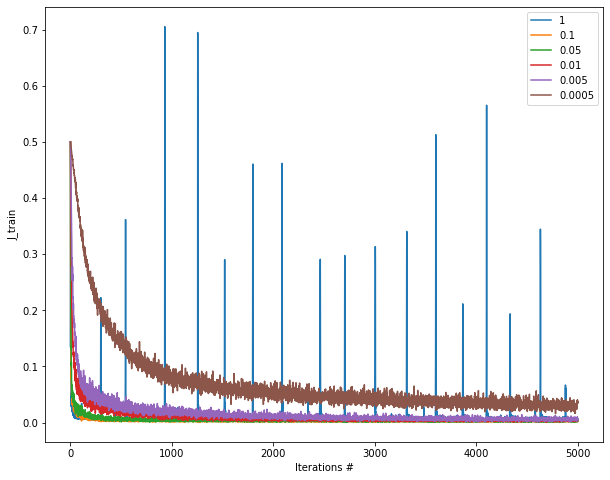

<Figure size 720x576 with 0 Axes>

In [4]:
##################################################################################
#  YOUR CODE HERE for training the best performing SVM for the data above.       #
#  what should C be? What should num_iters be? Should X be scaled?               #
#  should X be kernelized? What should the learning rate be? What should the     #
#  number of iterations be?                                                      #
##################################################################################
# optimize learning rate using learning curve
alpha = [1,1e-1,5e-2,1e-2,5e-3,5e-4]
fig = plt.figure()
for lr in alpha:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((XX.shape[1],))
    J_history = svm.train(XX,yy,learning_rate = lr,reg = 0.5,num_iters = 5000,verbose=False,batch_size= 500)
    plt.plot(range(len(J_history)), J_history)
plt.xlabel('Iterations #')
plt.ylabel('J_train')
plt.legend([str(a) for a in alpha])
plt.show()
plt.savefig("./Learning_curve_alpha.png")

Learning rate is chosen from 5e-4 to 1, we observe the learning curve shows large pertubations while $\alpha = 1 and 0.005, 0.0005, thus we chose the optimized learning rate as 0.01 since it converge fast and have low signal noice ratio. 

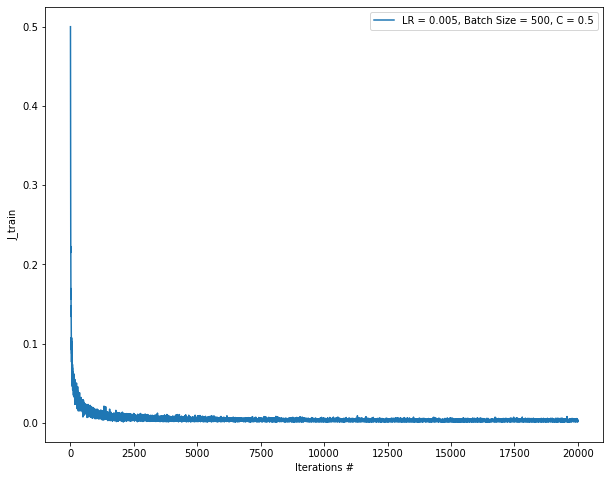

<Figure size 720x576 with 0 Axes>

In [8]:
# optimize the number of iterations using parameters when alpha equals to 0.005, batch size equals to 500, reg = 0.5 
lr = 0.01
svm = LinearSVM_twoclass()
svm.theta = np.zeros((XX.shape[1],))
# finalize num_iters as 20000 to search for the pivot point of training
J_history = svm.train(XX,yy,learning_rate = lr,reg = 0.5,num_iters = 20000,verbose=False,batch_size= 500)
plt.plot(range(len(J_history)), J_history)
plt.xlabel('Iterations #')
plt.ylabel('J_train')
plt.legend(["LR = 0.005, Batch Size = 500, C = 0.5"])
plt.show()
plt.savefig("./Long_iteration.png")

The learning curve reaches a platue when number of iterations get over 3000, for efficiency consideration we set the max iteration value as 3000 

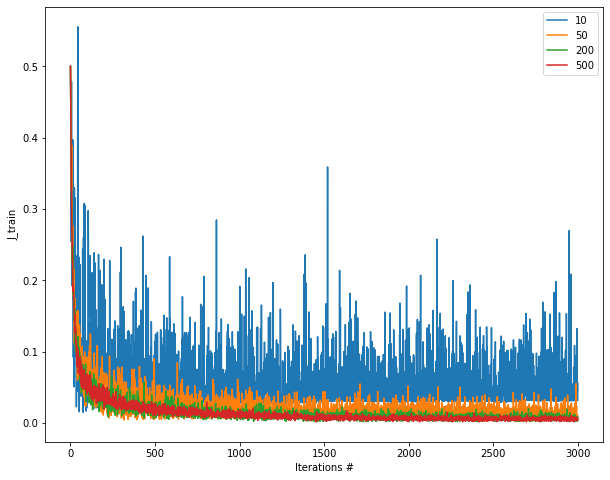

<Figure size 720x576 with 0 Axes>

In [6]:
# optimize the batch size
lr = 0.01
batches = [10,50,200,500]
fig = plt.figure()
for b in batches:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((XX.shape[1],))
    J_history = svm.train(XX,yy,learning_rate = lr,reg = 0.5,num_iters = 3000,verbose=False,batch_size= b)
    plt.plot(range(len(J_history)), J_history)
plt.xlabel('Iterations #')
plt.ylabel('J_train')
plt.legend([str(a) for a in batches])
plt.show()
plt.savefig("./Learning_curve_batches.png")

For small batch size such as 10, the learning curve shows large pertubations, while with learning curve at 200, the loss function J decrease smoothly, for efficiency concern we do not want larger batch size, thus the optimal batch size is set as 200  

In [13]:
# optimize the regularization 
lr, max_iter = 0.01, 3000
C = [0.005, 0.05, 0.1, 1, 3, 5]
b = 500
reg_opt, acc_opt = 0, 0
hist = {}
for c in C:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((XX.shape[1],))
    svm.train(XX,yy,learning_rate = lr,reg = c,num_iters = max_iter,verbose=False,batch_size= b)
    yy_pred_test = svm.predict(XX_test)
    acc = np.mean(yy_pred_test == yy_test)
    hist[c] = acc
    if acc > acc_opt:
        acc_opt = acc
        reg_opt = c
print ("Optimized test accuracy:", acc_opt, "regularization parameter:", reg_opt)
print(hist)

Optimized test accuracy: 0.98 regularization parameter: 0.1
{0.005: 0.954, 0.05: 0.976, 0.1: 0.98, 1: 0.978, 3: 0.974, 5: 0.973}


In [7]:
##################################################################################
# YOUR CODE HERE for testing your best model's performance                       #
# what is the accuracy of your best model on the test set? On the training set?  #
##################################################################################
lr, max_iter, batch_size, C, b = 0.01, 3000, 500, 0.1, 500
svm_opt = LinearSVM_twoclass()
svm_opt.theta = np.zeros((XX.shape[1],))
svm_opt.train(XX,yy,learning_rate = lr,reg = C,num_iters = max_iter,verbose=False,batch_size= b)
yy_pred_test = svm.predict(XX_test)
acc_test = np.mean(yy_pred_test == yy_test)
yy_pred = svm.predict(XX)
acc_train = np.mean(yy_pred == yy)
print("train acc:", acc_train, "test acc:",acc_test)

train acc: 0.98975 test acc: 0.98


In [36]:
##################################################################################
# ANALYSIS OF MODEL: Print the top 15 words that are predictive of spam and for  #
# ham. Hint: use the coefficient values of the learned model                     #
##################################################################################
words, inv_words = utils.get_vocab_dict()
print('Most spam words:')
rank = svm_opt.theta[1:].argsort()[::-1]
spam = []
for i in range(15):
    spam.append(words[rank[i]])
print('Most spam words:',spam)
##################################################################################
#                    END OF YOUR CODE                                            #
##################################################################################

Most spam words:
Most spam words: ['clearli', 'remot', 'base', 'herba', 'otherwis', 'natur', 'player', 'gt', 'franc', 'young', 'believ', 'york', 'creativ', 'off', 'hot']
